In [1]:
from qm import QuantumMachinesManager, QopCaps
from qm.qua import *
from configuration import *

2025-09-08 23:50:40,036 - qm - INFO     - Starting session: 42934c77-964f-4273-86d8-7b219f9bc368


In [ ]:
qmm = QuantumMachinesManager(host=qop_ip, port=None, cluster_name=cluster_name)
print(f"send program with config: {qmm.capabilities.supports(QopCaps.config_v2)}")

2025-09-08 23:50:44,247 - qm - INFO     - Performing health check
2025-09-08 23:50:44,600 - qm - INFO     - Cluster healthcheck completed successfully.
send program with config: True


In [4]:
resonator = "rr1"
n_avg = 100  # The number of averages

with program() as raw_trace_prog:
    n = declare(int)  # QUA variable for the averaging loop
    adc_st = declare_stream(adc_trace=True)  # The stream to store the raw ADC trace

    with for_(n, 0, n < n_avg, n + 1):
        # Reset the phase of the digital oscillator associated to the resonator element. Needed to average the cosine signal.
        reset_if_phase(resonator)
        # Sends the readout pulse and stores the raw ADC traces in the stream called "adc_st"
        measure("readout", resonator, adc_stream=adc_st)
        # Wait for the resonator to deplete
        wait(depletion_time * u.ns, resonator)

    with stream_processing():
        # Will save average:
        adc_st.input1().average().save("adc")
        # Will save only last run:
        adc_st.input1().save("adc_single_run")

In [5]:
# Open a quantum machine to execute the QUA program
qm = qmm.open_qm(full_config, close_other_machines=True)
# Send the QUA program to the OPX, which compiles and executes it
job = qm.execute(raw_trace_prog)
# Creates a result handle to fetch data from the OPX
res_handles = job.result_handles
# Waits (blocks the Python console) until all results have been acquired
results = res_handles.fetch_results(wait_until_done=True, timeout=60, stream_names=["adc", "adc_single_run"])
# Fetch the raw ADC traces and convert them into Volts
adc = u.raw2volts(results.get("adc"))
adc_single_run = u.raw2volts(results.get("adc_single_run"))

2025-09-08 23:50:45,200 - qm - INFO     - Clearing queue
2025-09-08 23:50:45,896 - qm - INFO     - Adding program to queue.
2025-09-08 23:50:47,354 - qm - INFO     - Job 3bb2eead-ec2e-42f5-ab45-0cae83ed746c is done


delay = 252.0ns


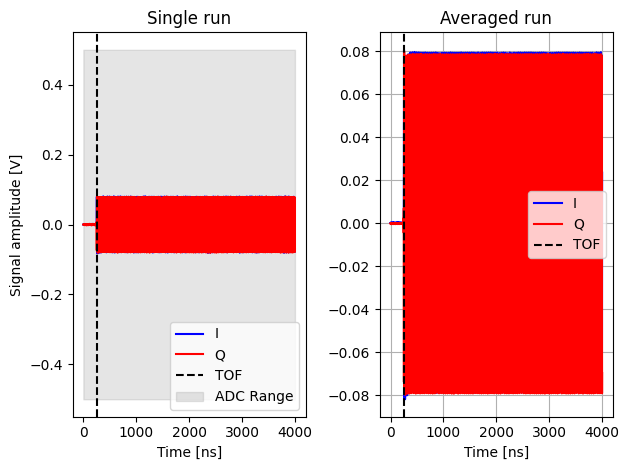

In [6]:
# find delay
delay = find_delay(adc)
# Plot data
fig = plot_adc(adc, adc_single_run, delay)

In [7]:
logical_config["elements"]["rr1"]["time_of_flight"] += int(delay)
job2 = qm.execute(raw_trace_prog, config=logical_config)
# Creates a result handle to fetch data from the OPX
res_handles = job2.result_handles
# Waits (blocks the Python console) until all results have been acquired
results = res_handles.fetch_results(wait_until_done=True, timeout=60, stream_names=["adc", "adc_single_run"])
# Fetch the raw ADC traces and convert them into Volts
adc = u.raw2volts(results.get("adc"))
adc_single_run = u.raw2volts(results.get("adc_single_run"))

2025-09-08 23:50:52,254 - qm - INFO     - Clearing queue
2025-09-08 23:50:52,949 - qm - INFO     - Adding program to queue.
2025-09-08 23:50:54,426 - qm - INFO     - Job 48f00baa-3597-4150-af94-14b41982f2f8 is done


delay = 0.0ns


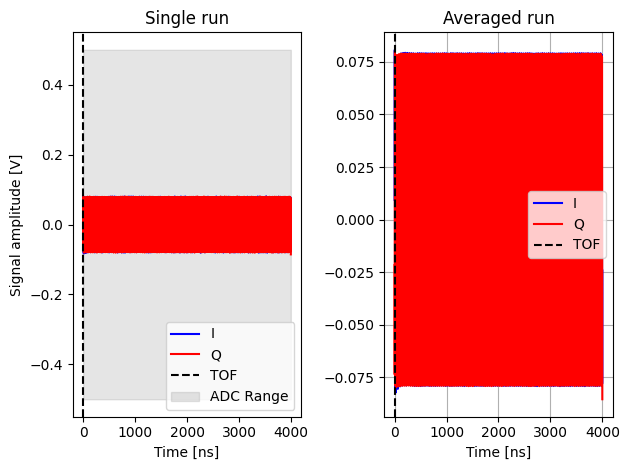

In [8]:
# find delay
delay = find_delay(adc)
# Plot data
fig = plot_adc(adc, adc_single_run, delay)

In [9]:
full_config = controller_config | logical_config  # store your config with calibrated values
qm.close()

True